# Deep Learning. Object Detection: You Only Look Once. Lesson 3
### Visión Artificial. GITT-GIEC
#### Luis M. Bergasa, David Fuentes-Jiménez y Miguel A. García. Department of Electronics. University of Alcalá. Spain

## Goal

The objective of this practice is to test the **YOLO object detection model** in conditions relatively close to reality, for which we will use a **pre-trained version** of it on the COCO database and then we will load this pre-training **to evaluate** its effectiveness on **real videos obtained from Youtube**, to analyse a police chase and a bank robbery.

The You Only Look Once (YOLO) algorithm is a state-of-the-art open source system for real-time object detection, which makes use of a single convolutional neural network to detect objects in images. To operate, the neural network divides the image into regions, predicting identification boxes and probabilities for each region; the boxes are weighted based on the predicted probabilities. The algorithm learns generalisable representations of the objects, allowing low detection error for new inputs, different from the training dataset.

The model was implemented as a convolutional neural network and evaluated on the PASCAL VOC detection dataset. The initial convolutional layers of the network handle image feature extraction, while the full connection layers predict the output probability and object coordinates. The network has 24 convolutional layers followed by 2 fully connection layers; it makes use of 1x1 reduction layers followed by 3x3 convolutional layers. For pre-training, use is made of the first 20 convolutional layers followed by a group averaging layer and a full connection layer; the resulting model is then converted for object detection.

For the object detection implementation, 4 convolutional layers and 2 full connection layers with randomly initialised weights are added. The last layer of the network predicts class probabilities and coordinates for the ID boxes; for this step the height and width of the ID box are normalised with respect to the image parameters, so that their values remain between 0 and 1. In the last layer an activation function is used, using a sum-squared error for the optimisation of the output. The YOLO algorithm predicts multiple identification frames per grid of cells. At training time, the aim is to have only one identification frame per object, which is achieved from the predicted probabilities for each frame, keeping the one with the highest probability.

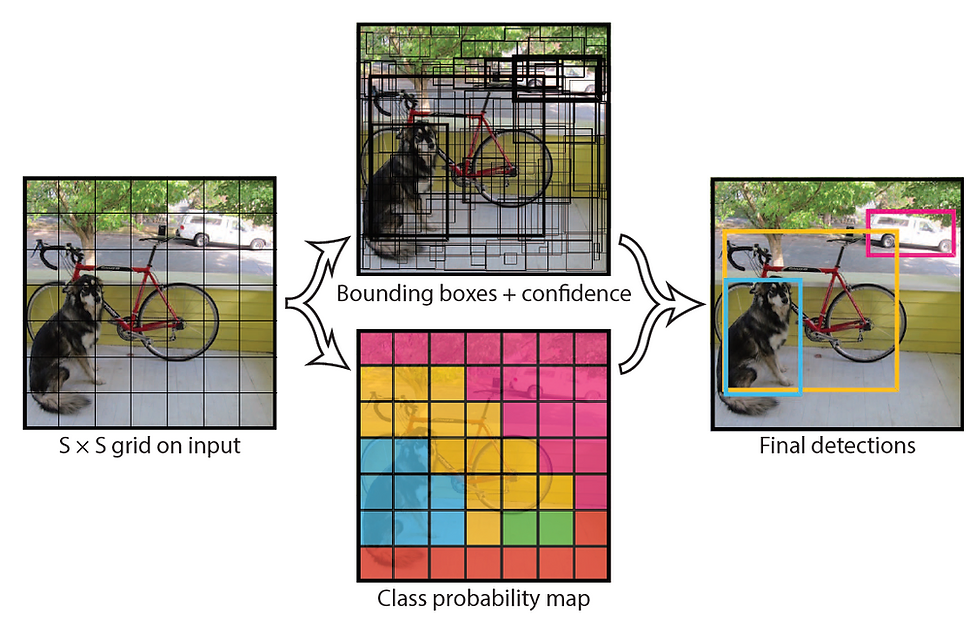

## Preliminaries

Before designing a YOLO(You Only Look Once), the corresponding libraries to be used must be imported.

In [2]:
import os
import cv2
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda,concatenate,LeakyReLU
VIDEO_OPTION=0
yolo_backend_path= 'full_yolo_backend.h5'   # name of the feature extractor to be used
configuration_path = 'config15anchors.json' #path to configuration file
weights_path = 'yolo_anchors_15.h5'#path to red yolo already trained


with open(configuration_path) as configuration_buffer:#Uploading of configuration file
    configuration = json.load(configuration_buffer)

ModuleNotFoundError: No module named 'cv2'

### Secondary functions

In the next cell all functions are defined that do not belong as such to the YOLO base coding but are indispensable for its use, either in terms of visualisation or functionally.

In [20]:
class DetectedBox: #Box Class---This is the format of Yolo's outputs.
    def __init__(self, xmin, ymin, xmax, ymax, c = None, clases = None):#Bounding Box Initialization
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        
        self.c     = c
        self.clases = clases

        self.label = -1
        self.score = -1

    def get_label(self):#Obtaining the label with the highest probability
        if self.label == -1:
            self.label = np.argmax(self.clases)
        
        return self.label
    
    def get_score(self):#Obtaining the score or probability assigned to the chosen label
        if self.score == -1:
            self.score = self.clases[self.get_label()]
            
        return self.score


def iou_boxes(box1, box2):#Intersection over the Union of Boxes or IOU calculation function
    width_intersection = overlap_interval([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    height_intersection = overlap_interval([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
    
    intersection = width_intersection * height_intersection

    width1, height1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
    width2, height2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    union = width1*height1 + width2*height2 - intersection
    
    return float(intersection) / union

def draw_detection(imagen, boxes, labels):#Yolo's output box drawing function
    image_height, image_width, _ = imagen.shape
    for box in boxes:
        xmin = int(box.xmin*image_width)#Obtaining the normalised xminimum with respect to the image width
        ymin = int(box.ymin*image_height)#Obtaining the minimum normalised yminimum with respect to the image height
        xmax = int(box.xmax*image_width)#Obtaining the normalised xmax with respect to the image width
        ymax = int(box.ymax*image_height)#Obtaining the minimum normalised yminimum with respect to the image height
        cv2.rectangle(imagen, (xmin,ymin), (xmax,ymax), (0,255,0), 2)#Drawing of rectangle
        cv2.putText(imagen, labels[box.get_label()] + ' ' + str(box.get_score()), (xmin, ymin - 13),
        cv2.FONT_HERSHEY_SIMPLEX, 1e-3 * image_height, (0,255,0), 2)#Label writing and confidence detection
        
    return imagen
        
def output_decode(net_output, base_size, nclasses, object_threshold=0.6, non_maximal_supression_thresh=0.8):#Decoding of Yolo outputs to boxed format
    grid_height, grid_width, boxes_number = net_output.shape[:3]#Grid width and height in relation to image

    boxes = []#List of boxes

    # output decoding
    net_output[..., 4]  = _sigmoid(net_output[..., 4])# Application of sigmoid activation to the confidence subset of the yolo output.
    net_output[..., 5:] = net_output[..., 4][..., np.newaxis] * _softmax(net_output[..., 5:])
    net_output[..., 5:] *= net_output[..., 5:] > object_threshold#Application of Softmax to class set and thresholding
    #according to the object threshold predefined by us

    #NOTE: Up to the fourth element X, Y, box width and box height are placed, from the fourth element onwards the box confidence and probabilities per class are placed.

    for row in range(grid_height):#Grid and box traversal loop to obtain the resulting boxes with the object threshold applied
        for col in range(grid_width):
            for b in range(boxes_number):
                # Define the classes to be detected
                clases = net_output[row,col,b,5:]#Class probs
                if np.sum(clases) > 0:#Class condition

                    x, y, w, h = net_output[row,col,b,:4]# Obtaining of X,Y,Width and Height of boxes

                    x = (col + _sigmoid(x)) / grid_width # Obtaining the X-coordinate of the upper corner of the box from the normalised outputs.
                    y = (row + _sigmoid(y)) / grid_height  # Obtaining the Y-coordinate of the upper corner of the box from the normalised outputs.
                    w = base_size[2 * b + 0] * np.exp(w) / grid_width # Obtaining the denormalised width of the proposed box from the possible widths and the exponential of the normalised width.
                    h = base_size[2 * b + 1] * np.exp(h) / grid_height # Obtaining the denormalised high of the proposed box from the possible highs and the exponential of the normalised high.
                    likelihood = net_output[row,col,b,4]#Obtaining the confidence of the various proposed boxes
                    
                    box = DetectedBox(x-w/2, y-h/2, x+w/2, y+h/2, likelihood, clases)#Obtaining the proposed box within the box class

                    boxes.append(box)

    # Box run loop to obtain the resulting boxes with the no maximum pit suppression threshold
    for c in range(nclasses):
        sorted_indexes = list(reversed(np.argsort([box.clases[c] for box in boxes])))

        for i in range(len(sorted_indexes)):
            index_i = sorted_indexes[i]
            
            if boxes[index_i].clases[c] == 0: 
                continue
            else:
                for j in range(i+1, len(sorted_indexes)):
                    index_j = sorted_indexes[j]
                    
                    if iou_boxes(boxes[index_i], boxes[index_j]) >= non_maximal_supression_thresh:#IOU threshold application for finding the best possible candidate boxes
                        boxes[index_j].clases[c] = 0

    boxes = [box for box in boxes if box.get_score() > object_threshold]#Eliminate those boxes whose threshold does not exceed the threshold of the object
    
    return boxes

        
def overlap_interval(interval_a, interval_b):#Box Overlapping Interval Calculation Function
    x1, x2 = interval_a
    x3, x4 = interval_b

    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3

def _sigmoid(x):#Sigmoid activation function
    return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):#Softmax activation function
    x = x - np.max(x)
    
    if np.min(x) < t:
        x = x/np.min(x)*t
        
    e_x = np.exp(x)
    
    return e_x / e_x.sum(axis, keepdims=True)


### Main Class and functions

The following code cell contains the heart of YOLO, meaning that it includes both the YOLO feature extractor and its base class, which in turn defines the initialisation, weight loading and prediction methods.

In [21]:
class BaseFeatureExtractor(object):# Base Class for possible feature extractors

    def __init__(self, input_shape):
        raise NotImplementedError("error message")

    def normalization(self, image):
        raise NotImplementedError("error message")

    def get_output_size(self):
        return self.feature_extractor.get_output_shape_at(-1)[1:3]

    def extract(self, input_image):
        return self.feature_extractor(input_image)

class FullYoloFeature(BaseFeatureExtractor):#Original Yolo feature extractor

    def __init__(self, input_shape):#Network initialization
        input_image = Input(shape=(input_shape, input_shape, 3))

        def space_to_depth_x2(x):
            return tf.nn.space_to_depth(x, block_size=2)#Yolo's special layer from space to depth

        # Layer 1
        x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
        x = BatchNormalization(name='norm_1')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 2
        x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
        x = BatchNormalization(name='norm_2')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 3
        x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
        x = BatchNormalization(name='norm_3')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 4
        x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
        x = BatchNormalization(name='norm_4')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 5
        x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
        x = BatchNormalization(name='norm_5')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 6
        x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
        x = BatchNormalization(name='norm_6')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 7
        x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
        x = BatchNormalization(name='norm_7')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 8
        x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
        x = BatchNormalization(name='norm_8')(x)
        x = LeakyReLU(alpha=0.1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 9
        x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
        x = BatchNormalization(name='norm_9')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 10
        x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
        x = BatchNormalization(name='norm_10')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 11
        x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
        x = BatchNormalization(name='norm_11')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 12
        x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
        x = BatchNormalization(name='norm_12')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 13
        x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
        x = BatchNormalization(name='norm_13')(x)
        x = LeakyReLU(alpha=0.1)(x)

        skip_connection = x

        x = MaxPooling2D(pool_size=(2, 2))(x)

        # Layer 14
        x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
        x = BatchNormalization(name='norm_14')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 15
        x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
        x = BatchNormalization(name='norm_15')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 16
        x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
        x = BatchNormalization(name='norm_16')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 17
        x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
        x = BatchNormalization(name='norm_17')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 18
        x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
        x = BatchNormalization(name='norm_18')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 19
        x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
        x = BatchNormalization(name='norm_19')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 20
        x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
        x = BatchNormalization(name='norm_20')(x)
        x = LeakyReLU(alpha=0.1)(x)

        # Layer 21
        skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
        skip_connection = BatchNormalization(name='norm_21')(skip_connection)
        skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
        skip_connection = Lambda(space_to_depth_x2)(skip_connection)

        x = concatenate([skip_connection, x])

        # Layer 22
        x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
        x = BatchNormalization(name='norm_22')(x)
        x = LeakyReLU(alpha=0.1)(x)

        self.feature_extractor = Model(input_image, x)
        self.feature_extractor.load_weights(yolo_backend_path)

    def normalization(self, image):#normalisation applied to input images
        return image / 255.



class YOLO(object):#Initialisation of the Yolo class, containing Yolo pre- and post-processing.
    def __init__(self, backend,input_shape, labels, max_boxes_each_image,base_sizes ):#Funcion de inicializacion de Yolo

        #Variables initialization
        self.input_shape = input_shape
        self.labels   = list(labels)
        self.number_classes = len(self.labels)
        self.boxes_number   = len(base_sizes)//2
        self.class_wt = np.ones(self.number_classes, dtype='float32')
        self.base_sizes  = base_sizes
        self.max_boxes_each_image =max_boxes_each_image

        #Model generation
        #1-Feature extractor generation
        input_image     = Input(shape=(self.input_shape, self.input_shape, 3))
        self.good_boxes = Input(shape=(1, 1, 1, max_boxes_each_image , 4))  

        self.feature_extractor = FullYoloFeature(self.input_shape)

        self.grid_height= self.feature_extractor.feature_extractor.output_shape[1]
        self.grid_width = self.feature_extractor.feature_extractor.output_shape[2]
        caracteristicas = self.feature_extractor.extract(input_image)            

        #2-Generation of output Layers adapted to the number of boxes, classes, etc.
        output = Conv2D(self.boxes_number * (4 + 1 + self.number_classes), (1,1), strides=(1,1), padding='same', name='DetectionLayer',kernel_initializer='lecun_normal')(caracteristicas)
        output = Reshape((self.grid_height, self.grid_width, self.boxes_number, 4 + 1 + self.number_classes))(output)
        output = Lambda(lambda args: args[0])([output, self.good_boxes])

        self.model = Model([input_image, self.good_boxes], output)
        
        #Initialisation of output Layer weights
        Layer = self.model.layers[-4]
        weights = Layer.get_weights()

        nuevo_kernel = np.random.normal(size=weights[0].shape)/(self.grid_height*self.grid_width)
        nuevo_bias   = np.random.normal(size=weights[1].shape)/(self.grid_height*self.grid_width)

        Layer.set_weights([nuevo_kernel, nuevo_bias])

        self.model.summary()


    def load_weights(self, weight_path):# Pre-trained weights loading function
        self.model.load_weights(weight_path)


    def predict(self, image,object_tresh,non_maximal_supression_thresh):#Prediction function
        image_height, image_width, _ = image.shape
        image = cv2.resize(image, (self.input_shape, self.input_shape))#Change input image size to Yolo's detection size
        image = self.feature_extractor.normalization(image)#normalization of the input image

        input_image = image[:,:,::-1]
        input_image = np.expand_dims(input_image, 0)
        dummy_array = np.zeros((1,1,1,1,self.max_boxes_each_image,4))

        netout = self.model.predict([input_image, dummy_array],verbose=0)[0]#prediction of the feature extractor model
        boxes  = output_decode(netout, self.base_sizes, self.number_classes,object_tresh,non_maximal_supression_thresh)#Decoding of the Yolo output in boxed format

        return boxes,netout



### Yolo definition and use in a video sequence

Finally, using the previously defined functions and classes, we invoke YOLO and load the previously saved pre-training, which has been performed on the COCO database. This allows us to evaluate an already pre-trained YOLO that can detect 91 different objects along each input image. Once we load the weights and the input videos using the VIDEO_OPTION flag, we will proceed to evaluate the input video frames using YOLO and visualise the detection results.

In [22]:
#NETWORK DEFINITION
#Creation of the Yolo model according to the configuration file
yolo = YOLO(backend             = configuration['model']['backend'],
            input_shape         = configuration['model']['input_size'],
            labels             = configuration['model']['labels'],
            max_boxes_each_image   = configuration['model']['max_box_each_image'],
            base_sizes            = configuration['model']['base_sizes'])
#Loading of previously trained Yolo net weights
yolo.load_weights(weights_path)

##################################################################################
#Video Load and preprocessing

if(VIDEO_OPTION==0):
    video_capture=cv2.VideoCapture('sample_1.mp4')#Bank Robbery example
elif(VIDEO_OPTION==1):
    video_capture=cv2.VideoCapture('sample_2.mp4')#Car chase example

native_FPS_of_video=video_capture.get(cv2.CAP_PROP_FPS)
ret, frame = video_capture.read()#Reading the first frame
print(frame.shape)
number_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
print('The number of frames of the video is=' + str(number_frames))

frame_counter=0
cv2.namedWindow('Output_video', cv2.WINDOW_NORMAL)#creation of reproduction window
while(frame_counter<number_frames-1):#reading loop
    #Image preprocessing to fit YOLO's input shape in terms of aspect ratio
    ret, frame = video_capture.read()#reading frames
    if(frame.shape[0]<frame.shape[1]):
        pad=int(frame.shape[1]/2)-int(frame.shape[0]/2)
        frame=cv2.copyMakeBorder(frame, pad, pad, 0, 0, cv2.BORDER_CONSTANT, 0)
    elif(frame.shape[0]>frame.shape[1]):
        pad=int(frame.shape[0]/2)-int(frame.hape[1]/2)
        frame=cv2.copyMakeBorder(frame, 0, 0,pad, pad,  cv2.BORDER_CONSTANT, 0)
        
    #YOLO prediction and drawing in the image
    [boxes,features] = yolo.predict(frame,0.3,0.1)#Yolo's predictions
    imageaux = draw_detection(frame, boxes, configuration['model']['labels'])#drawing of yolo detections in the image

    frame_counter=frame_counter+1
    cv2.imshow('Output_video',frame)
    key=cv2.waitKey(1)

    # Finish
    if  key == ord('q'):
         break

video_capture.release()
cv2.destroyAllWindows()            

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_14 (Functional)          (None, 13, 13, 1024  50547936    ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 DetectionLayer (Conv2D)        (None, 13, 13, 1275  1306875     ['model_14[0][0]']               
                                )                                                          

## Additional Questions

**1- YOLO have 2 thresholds, What is the purpose of each of them?, determine an approximate optimal value for the police car chase video and write it here. NOTE: Remember that with the VIDEO_OPTION variable set to 0 or 1, you switch between the two possible sample videos.**

In [5]:
#Answer

**3- Modify the code of YOLO(WITHOUT CHANGING ITS THRESHOLD) so that in the video of the bank robbery, it only and exclusively detects the object type "Person".**

In [7]:
#Answer. Change this sentence, making null of the probs, except the one that corresponds to the class person

net_output[row,col,b,6:]=0.0
clases = net_output[row,col,b,5:]#Class probs
